In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import MySQLdb as Mdb
from scipy.optimize import curve_fit
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
kinematics = {'xT': [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53]}
intensity = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000]
intensity_centers = (np.add(intensity[1:],intensity[:-1]))/2
schema = 'user_evan_recon_rate_dep'
server = 'seaquel.physics.illinois.edu'
server_dict = {'seaquel.physics.illinois.edu': 3283,
               'e906-db1.fnal.gov': 3306,
               'e906-db2.fnal.gov': 3306,
               'e906-db3.fnal.gov': 3306}
mass_range = [4.2, 10.0]
targetPos = 1
roadset = 62
merged_version = "R005_V001"

(0.08, 0.14]: p0 = 1.028 +/- 0.0154; p1 = -9.093e-06 +/- 1.41e-06
(0.14, 0.16]: p0 = 1.019 +/- 0.01468; p1 = -8.366e-06 +/- 1.349e-06
(0.16, 0.18]: p0 = 1.018 +/- 0.01253; p1 = -9.961e-06 +/- 9.315e-07
(0.18, 0.21]: p0 = 1.017 +/- 0.0122; p1 = -7.925e-06 +/- 1.073e-06
(0.21, 0.25]: p0 = 0.9794 +/- 0.01084; p1 = -8.295e-06 +/- 7.007e-07
(0.25, 0.31]: p0 = 0.9839 +/- 0.0104; p1 = -9.439e-06 +/- 6.601e-07
(0.31, 0.53]: p0 = 1.001 +/- 0.01105; p1 = -1.209e-05 +/- 7.266e-07


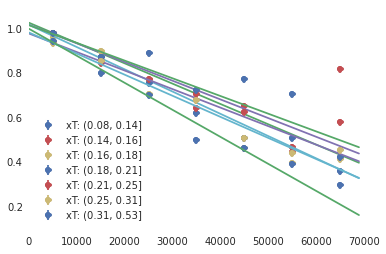

In [165]:
for kin_bin in eff.index.levels[0].values:
    popt, pcov = curve_fit(linear, intensity_centers, eff[kin_bin].values, sigma=eff_unc[kin_bin])
    print ("%s: p0 = %.4g +/- %.4g; p1 = %.4g +/- %.4g" %
           (kin_bin, popt[0], pcov[0,0]**0.5, popt[1], pcov[1,1]**0.5))
    ax = plt.errorbar(intensity_centers, eff[kin_bin].values,
                      yerr=eff_unc[kin_bin].values, fmt='o',
                      label=("%s: %s" % (eff.index.names[0], kin_bin)))
    plt.plot(x, linear(x,popt[0], popt[1]))
    #ax = eff[kin_bin].plot()
#plt.set_xticklabels(intensity_centers)
plt.legend(loc='best')

In [2]:
def lin_func(x, b, m):
        """
        A linear function:
        
        f(x) = b + m*x
        """
        return np.add(b,np.multiply(m,x))

In [126]:
class kEffCorrection(object):
    
    def __init__(self, roadset, targetPos, mass_range=(4.2,10.0),
                 kinematics={'xT': [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53]},
                 intensity=[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000],
                 schema='user_evan_recon_rate_dep',
                 merged_version='R005_V001',
                 server='seaquel.physics.illinois.edu'):
        # Create containers
        self.clean_df = pd.DataFrame()
        self.messy_df = pd.DataFrame()
        self.eff_df = pd.DataFrame()
        self.lin_df = pd.DataFrame()

        # Store relevant criteria
        self.intensity = intensity
        self.intensity_centers = (np.add(intensity[1:],intensity[:-1]))/2
        self.targetPos = targetPos
        self.roadset = roadset
        self.mass_range = mass_range
        self.kinematics = kinematics
        self.merged_version = merged_version
        
        # Manifest queries
        self.clean_query = self.make_query(kind='clean')
        self.messy_query = self.make_query(kind='messy')
        
        # Fetch relevant dimuon data
        self.clean_df = self.get_dimuons(self.clean_query, server, schema)
        self.messy_df = self.get_dimuons(self.messy_query, server, schema)
        
        # Get efficiencies for each kinematic and intensity bin
        self.eff_df = self.calc_eff()
        
        # Calculate linear fits to these efficiencies as a function of intensity
        self.lin_df = self.get_lin_fits()
        
        return None
    
    def make_query(self, kind='clean'):
        
        kin_str = ''
    
        # Select desired intensity range
        where = ("WHERE chamber_intensity BETWEEN %d AND %d" %
                 (self.intensity[0], self.intensity[-1]))
        # Add mass range requirement, if needed
        if self.mass_range and len(self.mass_range)==2:
            where += (" AND mass BETWEEN %f AND %f" %
                      (self.mass_range[0], self.mass_range[1]))
        # Select on cut kinematics and add ranges to WHERE clause
        for kinematic in self.kinematics.keys():
            kin_str += kinematic + ','
            where += (" AND %s BETWEEN %f AND %f" %
                      (kinematic, self.kinematics[kinematic][0],
                       self.kinematics[kinematic][-1]))
            
        # Assemble SELECT clause
        select = ("SELECT dimuonID, %s chamber_intensity, gmcWeight, "
                  "POW(gmcWeight,2) AS `gmcWeight_sq` FROM" % kin_str)

        # Put all together into two queries
        query = ("%s %s_%d_%d_%s %s" %
                 (select, kind, self.roadset, self.targetPos,
                 self.merged_version, where))
        
        return query
    
    
    def get_dimuons(self, query, server, schema):
        
        port = 3306
        df = pd.DataFrame()
        if server=='seaquel.physics.illinois.edu':
            port = 3283
    
        try:
            db = Mdb.connect(read_default_file='../.my.cnf',
                             read_default_group='guest',
                             db=schema,
                             host=server,
                             port=port)
            df = pd.read_sql(query, db, index_col='dimuonID')
            
            if db:
                db.close()

        except Mdb.Error, e:
            print "Error %d: %s" % (e.args[0], e.args[1])
            
        return df
    
    def calc_eff(self):
        
        eff_df = pd.DataFrame(columns=['raw_clean', 'weighted_clean', 'raw_messy',
                                       'weighted_messy', 'efficiency', 'uncertainty'])
        
        clean_cuts = []
        messy_cuts = []
        for kinematic in self.kinematics:
            clean_cuts.append(pd.cut(self.clean_df[kinematic],
                                     self.kinematics[kinematic]))
            messy_cuts.append(pd.cut(self.messy_df[kinematic],
                                     self.kinematics[kinematic]))
        
        clean_cuts.append(pd.cut(self.clean_df['chamber_intensity'],self.intensity))
        messy_cuts.append(pd.cut(self.messy_df['chamber_intensity'],self.intensity))
        
        eff_df['weighted_clean'] = self.clean_df.groupby(by=clean_cuts).gmcWeight.sum()
        eff_df['raw_clean'] = self.clean_df.groupby(by=clean_cuts).gmcWeight.count()
        eff_df['weighted_messy'] = self.messy_df.groupby(by=messy_cuts).gmcWeight.sum()
        eff_df['raw_messy'] = self.messy_df.groupby(by=messy_cuts).gmcWeight.count()
        eff_df['sqrt_sum_sq_weights_clean'] = np.sqrt(self.clean_df
                                                          .groupby(by=clean_cuts)
                                                          .gmcWeight_sq
                                                          .sum())
        
        eff_df['efficiency'] = eff_df['weighted_messy']/eff_df['weighted_clean']
        eff_df['uncertainty'] = np.sqrt(np.divide(eff_df.efficiency*(1.0-eff_df.efficiency),
                                                  eff_df.sqrt_sum_sq_weights_clean))
        
        return eff_df
    
    
    def get_lin_fits(self):
        """
        Internal function to calculate the linear fits to kinematic bins
        for which there is enough data.
        
        
        """
        
        #index = pd.MultiIndex.from_product(self.eff_df.index.names[:-1])
        #fits_df = pd.DataFrame(columns=['p0', 'p0_unc', 'p1', 'p1_unc'],
        #                       index=index)
        fits_list = []
        local_eff_df = self.eff_df.dropna(how='any').copy()
        
        # Use itertools.product to get every combination of the kinematic bins
        for bins in list(itertools.product(*self.eff_df.index.levels[:-1])):
            # Create a pandas query to select on that multi-dimensional bin
            where = ''
            n = 0
            
            for kin in self.kinematics.keys():
                where += ('%s == @bins[%d] and ' % (kin, n))
                n += 1
            # Chop off trailing ' and '
            where = where[:-5]
            # Collect slice of data
            slice_df = local_eff_df.query(where).copy()
            
            if len(slice_df)==len(self.intensity_centers):
                # Fit a linear curve to the efficiency
                popt, pcov = curve_fit(lin_func, self.intensity_centers,
                                       slice_df['efficiency'],
                                       sigma=slice_df['uncertainty'])

                fits_list.append([x for x in bins] + [popt[0], pcov[0,0]**0.5, popt[1], pcov[1,1]**0.5])
            
        fits_df = pd.DataFrame(fits_list,
                               columns=(self.eff_df.index.names[:-1] + ['p0', 'p0_unc', 'p1', 'p1_unc']))
        fits_df.set_index(self.eff_df.index.names[:-1], drop=True, inplace=True)
        return fits_df
    
    def kEff(self, x, unc=False, inv=False):
        """
        Main operating function of this class.
        
        Feed it in dimuon data with the same number of fields per row
          as self.kinematics + intensity, and it will spit out kEff factors
          
        Example:
          You have created a kEffCorrection object with the kinematics binned
          in xT and xB. In order to use this function, you must feed kEff() an array
          or array of arrays of [xT, xB, intensity], in that order.
          
        Output:
          A weight to apply to that dimuon. If an array is given, an array of weights is given.
          
        Options:
          'unc': Boolean. If true, the array will be a tuple of nominal and stddev values
          'inv': Boolean. If true, will return 1/kEff, which may be desirable
        """
        # Verify there is data, and in the right number of values per row.
        x = np.array(x)
        if len(x)==0:
            print "Empty set."
            return None
        if x.shape[1] != (len(self.kinematics) + 1):
            print ("Incorrect number of values per row. "
                   "There should be %d values per row: %s, and intensity" % 
                   (len(self.kinematics.keys())+1, ', '.join(self.kinematics.keys())))
            return None
        
        # Convert to DataFrame
        x_df = pd.DataFrame(x, columns=(self.kinematics.keys() + ['intensity']))
        
        # First group these dimuons into the same kinematic binning as used
        #   when calculating the efficiencies.
        cuts = []
        for kin in self.kinematics:
            cuts.append(pd.cut(x_df[kin],
                               self.kinematics[kin]))
        x_grp = x_df.groupby(by=cuts)

        # Rename the kinematic columns to make room for the binnin columns
        x_df = x_df.rename(columns={x:x+'_x' for x in self.kinematics.keys()})
        for kin in self.kinematics:
            x_df[kin] = None

        # Now we have the groups along with the indexes of the DataFrame
        #   that are in each bin. Let's put this all into a single list
        for group in x_grp.groups:
            indexes = x_grp.groups[group]
            x_df.ix[indexes, self.kinematics.keys()] = group

        _ = x_df.set_index(kinematics.keys(), inplace=True)
        
        # Get the fit parameters matched up to each row
        x_df = x_df.merge(self.lin_df, left_index=True, right_index=True,
                          how='left', sort=False)
        
        # Apply the fit parameters
        x_df['weight'] = x_df.apply(lambda x: x.p0 + x.p1*x.intensity, axis=1)
        x_df['weight_unc'] = x_df.apply(lambda x: np.sqrt(x.p0_unc**2 + (x.intensity*x.p1_unc)**2),
                                        axis=1)
        
        # Inverse the weights and their uncertainties if requested
        if inv:
            if unc:
                x_df['weight_unc'] = x_df['weight_unc']/(x_df['weight']**2)
            x_df['weight'] = 1.0/x_df['weight']
        
        # Return both weight and uncertainty if requested
        if unc:
            return x_df[['weight', 'weight_unc']].values
        else:
            return x_df['weight'].values
        
    
    #def plot_lin_fits(self, filename=None):
        
        

In [120]:
kinematics = {'xT': [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53],
              'xB': [0.0, 0.4, 0.6, 1.0]}

In [108]:
kinematics = {'xT': [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53]}

In [370]:
kinematics = {}

In [127]:
c1 = kEffCorrection(67, 3, mass_range=(4.2,300), kinematics=kinematics)

In [25]:
c1 = kEffCorrection(67, 3)

In [129]:
x = [[0.41, 0.23, 65000],[0.62, 0.24, 30001], [0.55, 0.11, 5000]]

In [110]:
x = [[0.3, 65000],[0.12, 30001]]

In [131]:
c1.eff_df

raw_clean  weighted_clean  \
xB         xT           chamber_intensity                              
(0, 0.4]   (0.21, 0.25] (0, 10000]                 1     1933.760010   
                        (20000, 30000]             1      871.372009   
           (0.25, 0.31] (0, 10000]                10     5142.059967   
                        (10000, 20000]             8     3495.080994   
                        (20000, 30000]             9     4478.532112   
                        (30000, 40000]             4     2538.025055   
                        (40000, 50000]             2      988.281982   
                        (50000, 60000]             1      931.758972   
           (0.31, 0.53] (0, 10000]               127    20485.701417   
                        (10000, 20000]            84    12833.031753   
                        (20000, 30000]            48     7077.089160   
                        (30000, 40000]            25     3010.282624   
                        (40000, 50000]            15     2824.570567   
                        (50000, 60000]            11     2450.498476   
                        (60000, 70000]            16     2546.204493   
(0.4, 0.6] (0.08, 0.14] (0, 10000]                 7     4732.440921   
                        (10000, 20000]             8     6326.902954   
                        (20000, 30000]             8     6910.108002   
                        (30000, 40000]             4     2849.606995   
                        (40000, 50000]             5     5575.841003   
           (0.14, 0.16] (0, 10000]               165   131759.751352   
                        (10000, 20000]           129    96773.015806   
                        (20000, 30000]            77    60441.188530   
                        (30000, 40000]            33    32220.086441   
                        (40000, 50000]            15    12340.911987   
                        (50000, 60000]            19    17653.716949   
                        (60000, 70000]            14     9627.718048   
           (0.16, 0.18] (0, 10000]               340   245569.973603   
                        (10000, 20000]           254   183090.324302   
                        (20000, 30000]           141    95956.312033   
...                                              ...             ...   
(0.6, 1]   (0.16, 0.18] (50000, 60000]           320    17379.984049   
                        (60000, 70000]           232    14756.854088   
           (0.18, 0.21] (0, 10000]              5344   246448.278424   
                        (10000, 20000]          3765   166703.454429   
                        (20000, 30000]          2414   108639.583287   
                        (30000, 40000]          1357    59701.373562   
                        (40000, 50000]           791    33984.140893   
                        (50000, 60000]           529    24484.602640   
                        (60000, 70000]           348    14514.933138   
           (0.21, 0.25] (0, 10000]              7016   185750.524406   
                        (10000, 20000]          5293   146550.581131   
                        (20000, 30000]          3168    88094.651234   
                        (30000, 40000]          1825    46907.852999   
                        (40000, 50000]          1144    30297.470788   
                        (50000, 60000]           754    21275.292926   
                        (60000, 70000]           472    11863.420660   
           (0.25, 0.31] (0, 10000]             10375   135864.505444   
                        (10000, 20000]          7446    95459.749485   
                        (20000, 30000]          4377    55619.554579   
                        (30000, 40000]          2665    36748.340709   
                        (40000, 50000]          1566    21281.083131   
                        (50000, 60000]          1018    12439.163076   
                        (60000, 70000]           771    10255.829252   
           

In [130]:
c1.kEff(x, inv=True)

                         xB_x  xT_x  intensity        p0    p0_unc        p1  \
xB         xT                                                                  
(0.4, 0.6] (0.21, 0.25]  0.41  0.23      65000  0.958746  0.018782 -0.000010   
(0.6, 1]   (0.21, 0.25]  0.62  0.24      30001  1.005079  0.011112 -0.000008   
(0.4, 0.6] (0.08, 0.14]  0.55  0.11       5000       NaN       NaN       NaN   

                               p1_unc    weight  weight_unc  
xB         xT                                                
(0.4, 0.6] (0.21, 0.25]  7.634189e-07  3.002547    0.053058  
(0.6, 1]   (0.21, 0.25]  5.558401e-07  1.323338    0.020039  
(0.4, 0.6] (0.08, 0.14]           NaN       NaN         NaN  


array([ 3.00254677,  1.32333775,         nan])

In [117]:
x = np.array(x)
if len(x)==0:
    print "Empty set."
if x.shape[1] != (len(kinematics) + 1):
    print ("Incorrect number of values per row. "
           "There should be %d values per row: %s, and intensity" % 
           (len(kinematics.keys())+1, ', '.join(kinematics.keys())))

# Convert to DataFrame
x_df = pd.DataFrame(x, columns=(kinematics.keys() + ['intensity']))

# First group these dimuons into the same kinematic binning as used
#   when calculating the efficiencies.
cuts = []
for kinematic in kinematics:
    cuts.append(pd.cut(x_df[kinematic],
                       kinematics[kinematic]))
x_grp = x_df.groupby(by=cuts)

# Rename the kinematic columns to make room for the binnin columns
x_df = x_df.rename(columns={x:x+'_x' for x in kinematics.keys()})
for kinematic in kinematics:
    x_df[kinematic] = None

# Now we have the groups along with the indexes of the DataFrame
#   that are in each bin. Let's put this all into a single list
for group in x_grp.groups:
    indexes = x_grp.groups[group]
    x_df.ix[indexes, kinematics.keys()] = group

_ = x_df.set_index(kinematics.keys(), inplace=True)

In [102]:
x_df.ix[[0],kinematics.keys()] = (2,4)

In [118]:
x_df

,,xB_x,xT_x,intensity
xB,xT,,,
"(0, 0.4]","(0.21, 0.25]",0.30,0.23,65000
"(0.6, 1]","(0.21, 0.25]",0.62,0.24,30001


In [698]:
c1.kEff(x, inv=True)

array([ 1.3315084 ,  1.27038786])

In [606]:
c1.eff_df

raw_clean  weighted_clean  \
xB         xT           chamber_intensity                              
(0, 0.4]   (0.21, 0.25] (0, 10000]                 1     1933.760010   
                        (20000, 30000]             1      871.372009   
           (0.25, 0.31] (0, 10000]                10     5142.059967   
                        (10000, 20000]             8     3495.080994   
                        (20000, 30000]             9     4478.532112   
                        (30000, 40000]             4     2538.025055   
                        (40000, 50000]             2      988.281982   
                        (50000, 60000]             1      931.758972   
           (0.31, 0.53] (0, 10000]               127    20485.701417   
                        (10000, 20000]            84    12833.031753   
                        (20000, 30000]            48     7077.089160   
                        (30000, 40000]            25     3010.282624   
                        (40000, 50000]            15     2824.570567   
                        (50000, 60000]            11     2450.498476   
                        (60000, 70000]            16     2546.204493   
(0.4, 0.6] (0.08, 0.14] (0, 10000]                 7     4732.440921   
                        (10000, 20000]             8     6326.902954   
                        (20000, 30000]             8     6910.108002   
                        (30000, 40000]             4     2849.606995   
                        (40000, 50000]             5     5575.841003   
           (0.14, 0.16] (0, 10000]               165   131759.751352   
                        (10000, 20000]           129    96773.015806   
                        (20000, 30000]            77    60441.188530   
                        (30000, 40000]            33    32220.086441   
                        (40000, 50000]            15    12340.911987   
                        (50000, 60000]            19    17653.716949   
                        (60000, 70000]            14     9627.718048   
           (0.16, 0.18] (0, 10000]               340   245569.973603   
                        (10000, 20000]           254   183090.324302   
                        (20000, 30000]           141    95956.312033   
...                                              ...             ...   
(0.6, 1]   (0.16, 0.18] (50000, 60000]           320    17379.984049   
                        (60000, 70000]           232    14756.854088   
           (0.18, 0.21] (0, 10000]              5344   246448.278424   
                        (10000, 20000]          3765   166703.454429   
                        (20000, 30000]          2414   108639.583287   
                        (30000, 40000]          1357    59701.373562   
                        (40000, 50000]           791    33984.140893   
                        (50000, 60000]           529    24484.602640   
                        (60000, 70000]           348    14514.933138   
           (0.21, 0.25] (0, 10000]              7016   185750.524406   
                        (10000, 20000]          5293   146550.581131   
                        (20000, 30000]          3168    88094.651234   
                        (30000, 40000]          1825    46907.852999   
                        (40000, 50000]          1144    30297.470788   
                        (50000, 60000]           754    21275.292926   
                        (60000, 70000]           472    11863.420660   
           (0.25, 0.31] (0, 10000]             10375   135864.505444   
                        (10000, 20000]          7446    95459.749485   
                        (20000, 30000]          4377    55619.554579   
                        (30000, 40000]          2665    36748.340709   
                        (40000, 50000]          1566    21281.083131   
                        (50000, 60000]          1018    12439.163076   
                        (60000, 70000]           771    10255.829252   
           

In [524]:
c1.lin_df

p0    p0_unc        p1        p1_unc
xB         xT                                                      
(0.4, 0.6] (0.14, 0.16]  0.976423  0.049585 -0.000010  2.026090e-06
           (0.16, 0.18]  1.012695  0.036981 -0.000011  1.475608e-06
           (0.18, 0.21]  0.988606  0.023267 -0.000011  9.756998e-07
           (0.21, 0.25]  0.958746  0.018782 -0.000010  7.634189e-07
           (0.25, 0.31]  0.977828  0.011317 -0.000012  4.178849e-07
           (0.31, 0.53]  0.948079  0.023814 -0.000011  8.846824e-07
(0.6, 1]   (0.08, 0.14]  1.003539  0.007006 -0.000008  3.340758e-07
           (0.14, 0.16]  1.011076  0.007824 -0.000009  3.797551e-07
           (0.16, 0.18]  1.012892  0.012792 -0.000008  6.858936e-07
           (0.18, 0.21]  1.008669  0.011535 -0.000009  5.808807e-07
           (0.21, 0.25]  1.005079  0.011112 -0.000008  5.558401e-07
           (0.25, 0.31]  1.001710  0.007451 -0.000008  3.555409e-07
           (0.31, 0.53]  1.028129  0.007833 -0.000010  4.130169e-07

In [386]:
c1.clean_query

'SELECT dimuonID, xT, chamber_intensity, gmcWeight, POW(gmcWeight,2) AS `gmcWeight_sq` FROM clean_67_3_R005_V001 WHERE chamber_intensity BETWEEN 0 AND 70000 AND mass BETWEEN 4.200000 AND 300.000000 AND xT BETWEEN 0.080000 AND 0.530000'